In [1]:
%matplotlib inline

In [1]:
from deepdow.benchmarks import Benchmark, OneOverN, Random
from deepdow.callbacks import EarlyStoppingCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.data.synthetic import sin_single
from deepdow.experiments import Run
from deepdow.layers import SoftmaxAllocator, RNN, NumericalMarkowitz, AverageCollapse, AttentionCollapse, CovarianceMatrix
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown, SortinoRatio, Alpha, CumulativeReturn, RiskParity, WorstReturn
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap, generate_cumrets
from deepdow.nn import BachelierNet
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
from deepdow.utils import prices_to_returns

In [3]:
import seaborn as sns   

In [4]:
torch.manual_seed(10)
np.random.seed(54)

## Data Creation -Ticker selection

In [5]:
import os

# load the key from the enviroment variables
api_key = os.environ.get('API_EOD')

from eod import EodHistoricalData

# Create the instance 
client = EodHistoricalData(api_key)
# predefine some instruments
symbol='BTC'
goverment_bond = 'SW10Y.GBOND'

# Quick usage
# weekly prices for the Swiss goverment bond
stock_prices = client.get_prices_eod(symbol, period='w', order='a')

In [6]:
stock_prices

[{'date': '2021-10-15',
  'open': 98.775,
  'high': 98.775,
  'low': 98.775,
  'close': 98.775,
  'adjusted_close': 98.775,
  'volume': 4},
 {'date': '2021-10-18',
  'open': 98.67,
  'high': 98.69,
  'low': 98.4,
  'close': 98.5118,
  'adjusted_close': 98.5118,
  'volume': 1406},
 {'date': '2021-10-25',
  'open': 98.57,
  'high': 98.77,
  'low': 98.57,
  'close': 98.6806,
  'adjusted_close': 98.6806,
  'volume': 51086},
 {'date': '2021-11-01',
  'open': 98.67,
  'high': 99.11,
  'low': 98.53,
  'close': 99.11,
  'adjusted_close': 99.11,
  'volume': 3572},
 {'date': '2021-11-08',
  'open': 98.95,
  'high': 99.064,
  'low': 98.55,
  'close': 98.6343,
  'adjusted_close': 98.6343,
  'volume': 4028},
 {'date': '2021-11-15',
  'open': 98.5071,
  'high': 98.64,
  'low': 98.45,
  'close': 98.605,
  'adjusted_close': 98.605,
  'volume': 1890},
 {'date': '2021-11-22',
  'open': 98.27,
  'high': 98.5999,
  'low': 98.1725,
  'close': 98.548,
  'adjusted_close': 98.548,
  'volume': 216},
 {'date': 

In [7]:
def enable_dropout(network):
    """Function to enable the dropout layers during test-time"""
    network.dropout_layer.train()

In [99]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [100]:
raw_df = yf.download(
    "VB EEM VGK XLP GOLD XLF TLT XLK VDE BOIL",
    start="2012-01-02",
    end="2022-09-23",
    progress=True,
)
raw_df.columns = raw_df.columns.swaplevel(0, 1)
raw_df.sort_index(axis=1, level=0, inplace=True)
tickers = "LNSTY EEM DAX VIX GOLD JPM SLV WMT BOIL NDX"

[*********************100%***********************]  10 of 10 completed


In [101]:
raw_df.isnull().sum()

BOIL  Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
EEM   Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
GOLD  Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
TLT   Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
VB    Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
VDE   Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
VGK   Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume       0
XLF   Adj Close    0
      Close        0
      High         0
      Low          0
      Open         0
      Volume 

In [102]:
data=raw_df.iloc[:,raw_df.columns.get_level_values(1)=='Close']

In [103]:
raw_df

BOIL                                            \
               Adj Close         Close          High           Low   
Date                                                                 
2012-01-03  20410.000000  20410.000000  20730.000000  19800.000000   
2012-01-04  22000.000000  22000.000000  22100.000000  20900.000000   
2012-01-05  20230.000000  20230.000000  21180.000000  19900.000000   
2012-01-06  21560.000000  21560.000000  21610.000000  20460.000000   
2012-01-09  20800.000000  20800.000000  20880.000000  20460.000000   
...                  ...           ...           ...           ...   
2022-09-16     72.139999     72.139999     77.769997     70.769997   
2022-09-19     74.220001     74.220001     74.550003     69.120003   
2022-09-20     70.650002     70.650002     75.820000     69.790001   
2022-09-21     72.220001     72.220001     74.949997     68.110001   
2022-09-22     62.369999     62.369999     70.449997     59.919998   

                                         EEM                                   \
                    Open   Volume  Adj Close      Close       High        Low   
Date                                                                            
2012-01-03  20550.000000       31  31.440714  39.099998  39.270000  38.889999   
2012-01-04  21040.000000       33  31.263813  38.880001  38.970001  38.599998   
2012-01-05  20950.000000       31  31.127104  38.709999  38.830002  38.330002   
2012-01-06  20740.000000       26  30.733082  38.220001  38.669998  38.200001   
2012-01-09  20800.000000        9  31.054735  38.619999  38.700001  38.369999   
...                  ...      ...        ...        ...        ...        ...   
2022-09-16     76.599998  1973100  37.790001  37.790001  37.910000  37.610001   
2022-09-19     69.720001  1968000  37.910000  37.910000  37.939999  37.459999   
2022-09-20     72.150002  1483800  37.700001  37.700001  37.869999  37.560001   
2022-09-21     74.889999  2064800  37.070000  37.070000  37.720001  37.020000   
2022-09-22     70.000000  2708600  36.889999  36.889999  37.150002  36.810001   

            ...         XLK                                          XLP  \
            ...        High         Low        Open    Volume  Adj Close   
Date        ...                                                            
2012-01-03  ...   26.020000   25.790001   25.870001  26839900  24.382977   
2012-01-04  ...   25.930000   25.660000   25.799999   4744300  24.330395   
2012-01-05  ...   26.010000   25.730000   25.850000   6756900  24.315371   
2012-01-06  ...   26.030001   25.850000   25.980000   4989200  24.157629   
2012-01-09  ...   26.080000   25.860001   26.059999   4086600  24.195181   
...         ...         ...         ...         ...       ...        ...   
2022-09-16  ...  128.979996  126.879997  128.300003  10378200  70.869003   
2022-09-19  ...  129.559998  127.029999  127.110001   7841500  71.339996   
2022-09-20  ...  129.490005  127.559998  128.229996   6054700  70.949997   
2022-09-21  ...  131.250000  126.650002  129.350006   8404400  70.680000   
2022-09-22  ...  126.760002  124.669998  125.959999   8016900  70.580002   

                                                                  
                Close       High        Low       Open    Volume  
Date                                                              
2012-01-03  32.459999  32.779999  32.450001  32.689999  20757900  
2012-01-04  32.389999  32.450001  32.290001  32.400002   6855200  
2012-01-05  32.369999  32.400002  32.169998  32.330002   4563000  
2012-01-06  32.160000  32.419998  32.099998  32.419998   6365900  
2012-01-09  32.209999  32.250000  32.119999  32.240002   3304900  
...               ...        ...        ...        ...       ...  
2022-09-16  71.330002  71.410004  70.900002  70.910004  13452600  
2022-09-19  71.339996  71.389999  70.599998  70.599998   9370400  
2022-09-20  70.949997  71.110001  70.400002  70.870003   9169900  
2022-09-21  70.680000  72.080002  7

In [104]:
data

,BOIL,EEM,GOLD,TLT,VB,VDE,VGK,XLF,XLK,XLP
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,
2012-01-03,20410.000000,39.099998,47.509998,119.430000,70.660004,103.540001,42.810001,10.836718,25.809999,32.459999
2012-01-04,22000.000000,38.880001,48.220001,118.010002,70.320000,103.849998,42.290001,10.804224,25.879999,32.389999
2012-01-05,20230.000000,38.709999,48.020000,117.800003,70.779999,103.410004,41.520000,10.950447,25.959999,32.369999
2012-01-06,21560.000000,38.220001,47.540001,118.730003,70.660004,102.779999,40.950001,10.885459,25.969999,32.160000
2012-01-09,20800.000000,38.619999,47.709999,118.519997,70.980003,103.169998,41.259998,10.942323,25.930000,32.209999
...,...,...,...,...,...,...,...,...,...,...
2022-09-16,72.139999,37.790001,15.300000,107.070000,185.970001,110.779999,50.590000,33.060001,128.710007,71.330002
2022-09-19,74.220001,37.910000,15.500000,107.320000,187.880005,111.000000,50.480000,33.259998,129.440002,71.339996


In [105]:
returns = prices_to_returns(data)

In [106]:
returns

,BOIL,EEM,GOLD,TLT,VB,VDE,VGK,XLF,XLK,XLP
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,
2012-01-04,0.075017,-0.005642,0.014834,-0.011961,-0.004823,0.002990,-0.012221,-0.003003,0.002708,-0.002159
2012-01-05,-0.083876,-0.004382,-0.004156,-0.001781,0.006520,-0.004246,-0.018375,0.013443,0.003086,-0.000618
2012-01-06,0.063673,-0.012739,-0.010046,0.007864,-0.001697,-0.006111,-0.013823,-0.005952,0.000385,-0.006509
2012-01-09,-0.035887,0.010411,0.003570,-0.001770,0.004519,0.003787,0.007542,0.005210,-0.001541,0.001553
2012-01-10,-0.066078,0.021517,0.012912,-0.001689,0.012600,0.008590,0.015154,0.017661,0.003465,0.003409
...,...,...,...,...,...,...,...,...,...,...
2022-09-16,-0.130547,-0.009219,0.010513,-0.008371,-0.016109,-0.023640,-0.008072,-0.009033,-0.005578,0.002386
2022-09-19,0.028425,0.003170,0.012987,0.002332,0.010218,0.001984,-0.002177,0.006031,0.005656,0.000140


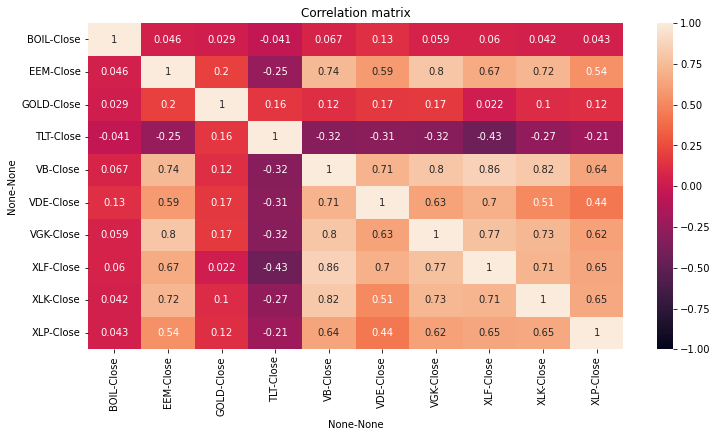

In [107]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(returns.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlation matrix')
plt.show()

In [108]:
covmat= returns.cov()

In [109]:
covmat

,,BOIL,EEM,GOLD,TLT,VB,VDE,VGK,XLF,XLK,XLP
,,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
BOIL,Close,0.003060,0.000034,0.000042,-0.000020,0.000046,0.000132,0.000040,0.000045,0.000031,0.000021
EEM,Close,0.000034,0.000173,0.000069,-0.000029,0.000121,0.000141,0.000127,0.000120,0.000127,0.000064
GOLD,Close,0.000042,0.000069,0.000661,0.000036,0.000038,0.000078,0.000054,0.000008,0.000036,0.000028
TLT,Close,-0.000020,-0.000029,0.000036,0.000080,-0.000035,-0.000051,-0.000035,-0.000053,-0.000032,-0.000017
VB,Close,0.000046,0.000121,0.000038,-0.000035,0.000156,0.000161,0.000121,0.000147,0.000136,0.000071
VDE,Close,0.000132,0.000141,0.000078,-0.000051,0.000161,0.000330,0.000139,0.000173,0.000124,0.000071
VGK,Close,0.000040,0.000127,0.000054,-0.000035,0.000121,0.000139,0.000147,0.000128,0.000119,0.000068
XLF,Close,0.000045,0.000120,0.000008,-0.000053,0.000147,0.000173,0.000128,0.000186,0.000130,0.000079
XLK,Close,0.000031,0.000127,0.000036,-0.000032,0.000136,0.000124,0.000119,0.000130,0.000178,0.000078


In [110]:
mean=returns.mean()

In [111]:
mean 

BOIL  Close   -0.002146
EEM   Close   -0.000022
GOLD  Close   -0.000426
TLT   Close   -0.000047
VB    Close    0.000342
VDE   Close    0.000015
VGK   Close    0.000046
XLF   Close    0.000396
XLK   Close    0.000586
XLP   Close    0.000288
dtype: float64

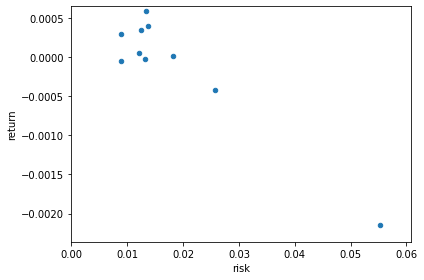

In [112]:
df_risk_ret = pd.DataFrame({'risk': np.diag(covmat) ** (1 / 2),
                            'return': mean})

x_lim = (0, df_risk_ret['risk'].max() * 1.1)
y_lim = (df_risk_ret['return'].min() * 1.1, df_risk_ret['return'].max() * 1.1)
ax = df_risk_ret.plot.scatter(x='risk', y='return')
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
plt.tight_layout()

<AxesSubplot:>

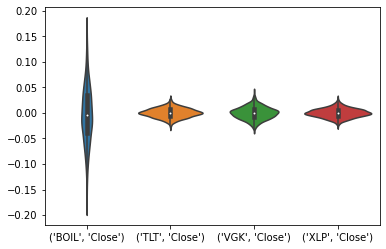

In [113]:
n_timesteps = 1500
returns = pd.DataFrame(np.random.multivariate_normal(mean.values,
                                                     covmat.values,
                                                     size=n_timesteps,
                                                     check_valid='raise'), columns=mean.index)

sns.violinplot(data=returns.iloc[:, ::3])

In [114]:
raw_df
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)

In [115]:
np.expand_dims(raw_df,axis=0)

array([[[2.04100000e+04, 2.04100000e+04, 2.07300000e+04, ...,
         3.24500008e+01, 3.26899986e+01, 2.07579000e+07],
        [2.20000000e+04, 2.20000000e+04, 2.21000000e+04, ...,
         3.22900009e+01, 3.24000015e+01, 6.85520000e+06],
        [2.02300000e+04, 2.02300000e+04, 2.11800000e+04, ...,
         3.21699982e+01, 3.23300018e+01, 4.56300000e+06],
        ...,
        [7.06500015e+01, 7.06500015e+01, 7.58199997e+01, ...,
         7.04000015e+01, 7.08700027e+01, 9.16990000e+06],
        [7.22200012e+01, 7.22200012e+01, 7.49499969e+01, ...,
         7.06399994e+01, 7.13799973e+01, 1.41897000e+07],
        [6.23699989e+01, 6.23699989e+01, 7.04499969e+01, ...,
         7.04499969e+01, 7.07399979e+01, 1.04284000e+07]]])

In [116]:
import deepdow
from deepdow.utils import raw_to_Xy


n_timesteps = len(raw_df) 
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

lookback, gap, horizon = 21, 1, 1

X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                      lookback=lookback,
                                                      gap=gap,
                                                      freq="B",
                                                      horizon=horizon)

n_samples =  n_timesteps - lookback - horizon - gap + 1  # 10

In [117]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:2140
Test range: 2163:2676


In [118]:
means, stds = prepare_standard_scaler(X, indices=indices_train)
print('mean: {}, std: {}'.format(means, stds))

mean: [-0.00012471 -0.00019965 -0.00020138 -0.00020213 -0.00020255  0.00053621], std: [0.0200039  0.02001967 0.01810551 0.01888936 0.01936255 0.45535445]


In [119]:
dataset = InRAMDataset(X, y, transform=Scale(means, stds))

In [120]:
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)

In [121]:
test = iter(dataset)
next(test)
a,b,c,d= next(test)
a.shape, b.shape, c, d

(torch.Size([6, 21, 10]),
 torch.Size([6, 1, 10]),
 1,
 ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'a_5', 'a_6', 'a_7', 'a_8', 'a_9'])

## Model Creation

In [122]:
loss = SortinoRatio()

In [132]:
n_input_channels = 6
n_assets = 10
max_weight = 0.2
hidden_size = 32
network = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)

print(network)

BachelierNet(
  (norm_layer): InstanceNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (transform_layer): RNN(
    (cell): LSTM(6, 16, bidirectional=True)
  )
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (time_collapse_layer): AttentionCollapse(
    (affine): Linear(in_features=32, out_features=32, bias=True)
    (context_vector): Linear(in_features=32, out_features=1, bias=False)
  )
  (covariance_layer): CovarianceMatrix()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): NumericalMarkowitz(
    (cvxpylayer): CvxpyLayer()
  )
)


In [133]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

In [134]:
inp1,inp2,inp3,inp4 = next(iter(dataloader_train))
inp1.shape,

(torch.Size([32, 6, 21, 10]),)

In [135]:
history = run.launch(30)

Epoch 29: 100%|██████████| 67/67 [00:57<00:00,  1.17it/s, loss=-47.90217, test_loss=-69.84293]


In [127]:
def enable_dropout(network):

    """Function to enable the dropout layers during test-time"""
    network.dropout_layer.train()

In [128]:
n_input_channels = 6
n_assets = 10
max_weight = 0.2
hidden_size = 32
network2 = BachelierNet(n_input_channels, n_assets, hidden_size=hidden_size, max_weight=max_weight)

print(network2)

BachelierNet(
  (norm_layer): InstanceNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (transform_layer): RNN(
    (cell): LSTM(6, 16, bidirectional=True)
  )
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (time_collapse_layer): AttentionCollapse(
    (affine): Linear(in_features=32, out_features=32, bias=True)
    (context_vector): Linear(in_features=32, out_features=1, bias=False)
  )
  (covariance_layer): CovarianceMatrix()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): NumericalMarkowitz(
    (cvxpylayer): CvxpyLayer()
  )
)


In [129]:
enable_dropout(network2)

In [130]:
run2 = Run(network2,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test},
          optimizer=torch.optim.Adam(network2.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)])

In [131]:
history = run2.launch(30)

Epoch 29: 100%|██████████| 67/67 [00:57<00:00,  1.17it/s, loss=-46.92657, test_loss=-70.14883]


In [ ]:
network=network.eval()
network2=network2.eval()

In [48]:
def log2simple(x):
    """Turn simple returns into log returns.

    r_simple = exp(r_log) - 1.

    Parameters
    ----------
    x : torch.Tensor
        Tensor of any shape where each entry represents a simple return.

    Returns
    -------
    torch.Tensor
        Logarithmic returns.

    """
    return torch.exp(x) - 1
    
def simple2log(x):
    """Turn log returns into simple returns.

    r_log = ln(r_simple + 1).

    Parameters
    ----------
    x : torch.Tensor
        Tensor of any shape where each entry represents a logarithmic return.

    Returns
    -------
    torch.Tensor
        Simple returns.

    """
    return torch.log(x + 1)
    

In [49]:
def portfolio_returns(weights, y, input_type='log', output_type='simple', rebalance=False):
    """Compute portfolio returns.

    Parameters
    ----------
    weights : torch.Tensor
        Tensor of shape (n_samples, n_assets) representing the simple buy and hold strategy over the horizon.

    y : torch.Tensor
        Tensor of shape (n_samples, horizon, n_assets) representing single period non-cumulative returns.

    input_type : str, {'log', 'simple'}
        What type of returns are we dealing with in `y`.

    output_type : str, {'log', 'simple'}
        What type of returns are we dealing with in the output.

    rebalance : bool
        If True, each timestep the weights are adjusted to be equal to be equal to the original ones. Note that
        this assumes that we tinker with the portfolio. If False, the portfolio evolves untouched.

    Returns
    -------
    portfolio_returns : torch.Tensor
        Of shape (n_samples, horizon) representing per timestep portfolio returns.

    """
    if input_type == 'log':
        simple_returns = log2simple(y)

    elif input_type == 'simple':
        simple_returns = y

    else:
        raise ValueError('Unsupported input type: {}'.format(input_type))

    n_samples, horizon, n_assets = simple_returns.shape

    weights_ = weights.view(n_samples, 1, n_assets).repeat(1, horizon, 1)  # (n_samples, horizon, n_assets)

    if not rebalance:
        weights_unscaled = (1 + simple_returns).cumprod(1)[:, :-1, :] * weights_[:, 1:, :]
        weights_[:, 1:, :] = weights_unscaled / weights_unscaled.sum(2, keepdim=True)

    out = (simple_returns * weights_).sum(-1)

    if output_type == 'log':
        return simple2log(out)

    elif output_type == 'simple':
        return out

    else:
        raise ValueError('Unsupported output type: {}'.format(output_type))


In [50]:
from types import MethodType

In [51]:
class Loss:
    """Parent class for all losses.

    Additionally it implement +, -, * and / operation between losses.
    """

    def _call(self, weights, y):
        raise NotImplementedError()

    def _repr(self):
        raise NotImplementedError()

    def __call__(self, weights, y):
        """Compute loss.

        Parameters
        ----------
        weights : torch.Tensor
            Tensor of shape `(n_samples, n_assets)` representing the predicted weights by our portfolio optimizer.

        y : torch.Tensor
            Tensor of shape `(n_samples, n_input_channels, horizon, n_assets)` representing ground truth labels
            over the `horizon` of steps. The idea is that the channel dimensions can be given a specific meaning
            in the constructor.

        Returns
        -------
        torch.Tensor
            Tensor of shape `(n_samples,)` representing the per sample loss.

        """
        return self._call(weights, y)

    def __repr__(self):
        """Generate representation string.

        The goal is two generate a string `s` that we can `eval(s)` to instantiate the loss.
        """
        return self._repr()

    def __add__(self, other):
        """Add two losses together.

        Parameters
        ----------
        other : Loss or int or float
            If instance of ``Loss`` then creates a new loss that represents the sum of `self` and `other`. If a number
            then create a new loss that is equal to `self` plus a constant.

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the addition operation.
        """
        if isinstance(other, Loss):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) + other(weights, y), new_instance)
            new_instance._repr = MethodType(lambda inst: '{} + {}'.format(self.__repr__(), other.__repr__()),
                                            new_instance)

            return new_instance

        elif isinstance(other, (int, float)):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) + other, new_instance)
            new_instance._repr = MethodType(lambda inst: '{} + {}'.format(self.__repr__(), other),
                                            new_instance)

            return new_instance
        else:
            raise TypeError('Unsupported type: {}'.format(type(other)))

    def __radd__(self, other):
        """Add two losses together.

        Parameters
        ----------
        other : Loss or int or float
            If instance of ``Loss`` then creates a new loss that represents the sum of `self` and `other`. If a number
            then create a new loss that is equal to `self` plus a constant.

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the addition operation.
        """
        return self.__add__(other)

    def __mul__(self, other):
        """Multiply two losses together.

        Parameters
        ----------
        other : Loss or int or float
            If instance of ``Loss`` then creates a new loss that represents the product of `self` and `other`. If a
            number then create a new loss that is equal to `self` times a constant.

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the multiplication operation.
        """
        if isinstance(other, Loss):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) * other(weights, y), new_instance)
            new_instance._repr = MethodType(lambda inst: '{} * {}'.format(self.__repr__(), other.__repr__()),
                                            new_instance)

            return new_instance

        elif isinstance(other, (int, float)):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) * other, new_instance)
            new_instance._repr = MethodType(lambda inst: '{} * {}'.format(self.__repr__(), other),
                                            new_instance)

            return new_instance
        else:
            raise TypeError('Unsupported type: {}'.format(type(other)))

    def __rmul__(self, other):
        """Multiply two losses together.

        Parameters
        ----------
        other : Loss or int or float
            If instance of ``Loss`` then creates a new loss that represents the product of `self` and `other`. If a
            number then create a new loss that is equal to `self` times a constant.

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the multiplication operation.
        """
        return self.__mul__(other)

    def __truediv__(self, other):
        """Divide two losses together.

        Parameters
        ----------
        other : Loss or int or float
            If instance of ``Loss`` then creates a new loss that represents the ratio of `self` and `other`. If a
            number then create a new loss that is equal to `self` divided a constant.

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the division operation.
        """
        if isinstance(other, Loss):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) / other(weights, y), new_instance)
            new_instance._repr = MethodType(lambda inst: '{} / {}'.format(self.__repr__(), other.__repr__()),
                                            new_instance)

            return new_instance

        elif isinstance(other, (int, float)):
            if other == 0:
                raise ZeroDivisionError()

            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) / other, new_instance)
            new_instance._repr = MethodType(lambda inst: '{} / {}'.format(self.__repr__(), other),
                                            new_instance)

            return new_instance
        else:
            raise TypeError('Unsupported type: {}'.format(type(other)))

    def __pow__(self, power):
        """Put a loss to a power.

        Parameters
        ----------
        power : int or float
            Number representing the exponent

        Returns
        -------
        new : Loss
            Instance of a ``Loss`` representing the `self ** power`.
        """
        if isinstance(power, (int, float)):
            new_instance = Loss()
            new_instance._call = MethodType(lambda inst, weights, y: self(weights, y) ** power, new_instance)
            new_instance._repr = MethodType(lambda inst: '({}) ** {}'.format(self.__repr__(), power),
                                            new_instance)

            return new_instance
        else:
            raise TypeError('Unsupported type: {}'.format(type(power)))

In [52]:
class SharpeRatio(Loss):
    """Negative Sharpe ratio.

    Parameters
    ----------
    rf : float
        Risk-free rate.

    returns_channel : int
        Which channel of the `y` target represents returns.

    input_type : str, {'log', 'simple'}
        What type of returns are we dealing with in `y`.

    output_type : str, {'log', 'simple'}
        What type of returns are we dealing with in the output.

    eps : float
        Additional constant added to the denominator to avoid division by zero.
    """

    def __init__(self, rf=0, returns_channel=0, input_type='simple', output_type='log', eps=1e-4):
        self.rf = rf
        self.returns_channel = returns_channel
        self.input_type = input_type
        self.output_type = output_type
        self.eps = eps

    def __call__(self, weights, y):
        """Compute negative sharpe ratio.

        Parameters
        ----------
        weights : torch.Tensor
            Tensor of shape `(n_samples, n_assets)` representing the predicted weights by our portfolio optimizer.

        y : torch.Tensor
            Tensor of shape `(n_samples, n_channels, horizon, n_assets)` representing the evolution over the next
            `horizon` timesteps.

        Returns
        -------
        torch.Tensor
            Tensor of shape `(n_samples,)` representing the per sample negative sharpe ratio.

        """
        prets = portfolio_returns(weights,
                                  y[:, self.returns_channel, ...],
                                  input_type=self.input_type,
                                  output_type=self.output_type)

        return -(prets.mean(dim=1) - self.rf) / (prets.std(dim=0) + self.eps)

    def __repr__(self):
        """Generate representation string."""
        return "{}(rf={}, returns_channel={}, input_type='{}', output_type='{}', eps={})".format(
            self.__class__.__name__,
            self.rf,
            self.returns_channel,
            self.input_type,
            self.output_type,
            self.eps)

In [143]:
benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'random': Random(),  # random allocation that is however close 1OverN
    'network': network,
    'Monte Carlo': network2
}

In [144]:
class RiskParity(Loss):
    """Risk Parity Portfolio.

    Parameters
    ----------
    returns_channel : int
        Which channel of the `y` target represents returns.

    Attributes
    ----------
    covariance_layer : deepdow.layers.CoverianceMatrix
        Covarioance matrix layer.

    References
    ----------
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2297383
    """

    def __init__(self, returns_channel=0):
        self.returns_channel = returns_channel
        self.covariance_layer = CovarianceMatrix(sqrt=False)

    def __call__(self, weights, y):
        """Compute loss.

        Parameters
        ----------
        weights : torch.Tensor
            Tensor of shape `(n_samples, n_assets)` representing the predicted
            weights by our portfolio optimizer.

        y : torch.Tensor
            Tensor of shape `(n_samples, n_channels, horizon, n_assets)`
            representing the evolution over the next `horizon` timesteps.

        Returns
        -------
         torch.Tensor
            Tensor of shape `(n_samples,)` representing the per sample risk parity.
        """
        n_assets = weights.shape[-1]
        covar = self.covariance_layer(y[:, self.returns_channel, ...])  # (n_samples, n_assets, n_assets)

        weights = weights.unsqueeze(dim=1)
        volatility = torch.sqrt(torch.matmul(weights,
                                             torch.matmul(covar,
                                                          weights.permute((0, 2, 1)))))  # (n_samples, 1, 1)
        c = (covar * weights) / volatility  # (n_samples, n_assets, n_assets)
        risk = volatility / n_assets  # (n_samples, 1, 1)

        budget = torch.matmul(weights, c)  # (n_samples, n_assets, n_assets)
        rp = torch.sum((risk - budget)**2, dim=-1).view(-1)  # (n_samples,)

        return rp

    def __repr__(self):
        """Generate representation string."""
        return "{}(returns_channel={})".format(self.__class__.__name__,
                                               self.returns_channel)

In [145]:
from deepdow.losses import portfolio_cumulative_returns
class CumulativeReturn(Loss):
    """Negative cumulative returns.

    Parameters
    ----------
    returns_channel : int
        Which channel of the `y` target represents returns.

    input_type : str, {'log', 'simple'}
        What type of returns are we dealing with in `y`.
    """

    def __init__(self, returns_channel=0, input_type='log'):
        self.returns_channel = returns_channel
        self.input_type = input_type

    def __call__(self, weights, y):
        """Compute negative simple cumulative returns.

        Parameters
        ----------
        weights : torch.Tensor
            Tensor of shape `(n_samples, n_assets)` representing the predicted weights by our portfolio optimizer.

        y : torch.Tensor
            Tensor of shape `(n_samples, n_channels, horizon, n_assets)` representing the evolution over the next
            `horizon` timesteps.

        Returns
        -------
        torch.Tensor
            Tensor of shape `(n_samples,)` representing the per sample negative simple cumulative returns.

        """
        crets = portfolio_cumulative_returns(weights,
                                             y[:, self.returns_channel, ...],
                                             input_type=self.input_type,
                                             output_type='simple')

        return -crets[:, -1]

    def __repr__(self):
        """Generate representation string."""
        return "{}(returns_channel={}, input_type='{}')".format(self.__class__.__name__,
                                                                self.returns_channel,
                                                                self.input_type)

In [146]:
metrics = {
    #'MaxDD': RiskParity(),
    'MeanReturn': CumulativeReturn(),
    'Sharpe': SharpeRatio(),
    
}

In [147]:
def generate_metrics_table(benchmarks, dataloader, metrics, device=None, dtype=None):
    """Generate metrics table for all benchmarks.

    Parameters
    ----------
    benchmarks : dict
        Dictionary where keys are benchmark names and values are instances of `Benchmark` (possible
        also `torch.nn.Network`).

    dataloader : deepdow.data.RigidDataLoader
        Dataloader that we will fully iterate over.

    metrics : dict
        Keys are metric names and values are instances of `deepdow.loss.Loss` representing. They
        all have the logic the lower the better.

    device : torch.device or None
        Device to be used. If not specified defaults to `torch.device('cpu')`.

    dtype : torch.dtype or None
        Dtype to be used. If not specified defaults to `torch.float`.

    Returns
    -------
    metrics_table : pd.DataFrame
        Table with the following columns - 'metric', 'timestamp', 'benchmark' and 'value'.

    """
    # checks
    if not all(isinstance(bm, Benchmark) for bm in benchmarks.values()):
        raise TypeError('The values of benchmarks need to be of type Benchmark')

    if not isinstance(dataloader, RigidDataLoader):
        raise TypeError('The type of dataloader needs to be RigidDataLoader')

    if not all(isinstance(metric, Loss) for metric in metrics.values()):
        raise TypeError('The values of metrics need to be of type Loss')

    device = device or torch.device('cpu')
    dtype = dtype or torch.float

    for bm in benchmarks.values():
        if isinstance(bm, torch.nn.Module):
            bm.eval()

    all_entries = []

    for batch_ix, (X_batch, y_batch, timestamps, _) in enumerate(dataloader):
        # Get batch
        X_batch, y_batch = X_batch.to(device).to(dtype), y_batch.to(device).to(dtype)
        for bm_name, bm in benchmarks.items():
            weights = bm(X_batch)
            for metric_name, metric in metrics.items():
                metric_per_s = metric(weights, y_batch).detach().cpu().numpy()
                all_entries.append(pd.DataFrame({'timestamp': timestamps,
                                                 'benchmark': bm_name,
                                                 'metric': metric_name,
                                                 'value': metric_per_s}))

    metrics_table = pd.concat(all_entries)

    return metrics_table

In [148]:
metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics)

array([<AxesSubplot:title={'center':'MeanReturn'}, xlabel='timestamp'>,
       <AxesSubplot:title={'center':'Sharpe'}, xlabel='timestamp'>],
      dtype=object)

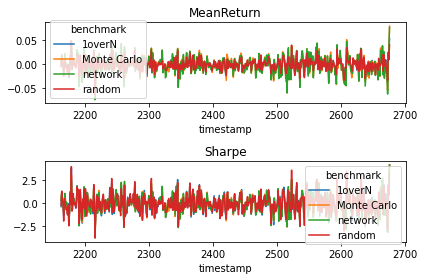

In [149]:
plot_metrics(metrics_table)

In [150]:
dict=generate_cumrets(benchmarks,dataloader_test)

**Variational RNN**

In [62]:
import pandas as pd
import numpy as np
import deepdow
from deepdow import utils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM, BayesianLinear
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [63]:
window_size = 21

In [64]:
def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [65]:
from deepdow.utils import prices_to_returns, returns_to_Xy

def raw_to_Xy(
    raw_data,
    lookback=21,
    horizon=1,
    gap=1,
    freq="B",
    included_assets=None,
    included_indicators=None,
    use_log=True,
):
    """Convert raw data to features.

    Parameters
    ----------
    raw_data : pd.DataFrame
        Rows represents different timestamps stored in index. Note that there can be gaps. Columns are pd.MultiIndex
        with the zero level being assets and the first level indicator.

    lookback : int
        Number of timesteps to include in the features.

    horizon : int
        Number of timesteps to included in the label.

    gap : int
        Integer representing the number of time periods one cannot act after observing the features.

    freq : str
        Periodicity of the data.

    included_assets : None or list
        Assets to be included. If None then all available.

    included_indicators : None or list
        Indicators to be included. If None then all available.

    use_log : bool
        If True, then logarithmic returns are used (natural logarithm). If False, then simple returns.

    Returns
    -------
    X : np.ndarray
        Feature array of shape `(n_samples, n_indicators, lookback, n_assets)`.

    timestamps : pd.DateTimeIndex
        Per row timestamp of shape length `n_samples`.

    y : np.ndarray
        Targets array of shape `(n_samples, n_indicators, horizon, n_assets)`.

    asset_names : list
        Names of assets.

    indicators : list
        List of indicators.
    """
    if freq is None:
        raise ValueError("Frequency freq needs to be specified.")

    asset_names = (
        included_assets
        if included_assets is not None
        else raw_data.columns.levels[0].to_list()
    )
    indicators = (
        included_indicators
        if included_indicators is not None
        else raw_data.columns.levels[1].to_list()
    )

    index = pd.date_range(start=raw_data.index[0], end=raw_data.index[-1], freq=freq)

    new = pd.DataFrame(raw_data, index=index).ffill().bfill()

    to_exclude = []
    for a in asset_names:
        is_valid = np.all(np.isfinite(new[a])) and np.all(new[a] > 0)
        if not is_valid:
            print(a, "is not valid")
            to_exclude.append(a)

    asset_names = sorted(list(set(asset_names) - set(to_exclude)))

    absolute = new.iloc[:, new.columns.get_level_values(0).isin(asset_names)][
        asset_names
    ]  # sort
    absolute = absolute.iloc[:, absolute.columns.get_level_values(1).isin(indicators)]

    returns = prices_to_returns(absolute, use_log=use_log)

    X_list = []
    y_list = []
    for ind in indicators:
        X, timestamps, y = returns_to_Xy(
            returns.xs(ind, axis=1, level=1),
            lookback=lookback,
            horizon=horizon,
            gap=gap,
        )
        X_list.append(X)
        y_list.append(y)

    X = np.concatenate(X_list, axis=1)
    y = np.concatenate(y_list, axis=1)

    return X, timestamps, y, asset_names, indicators


In [66]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(raw_df,
                                                     lookback=window_size,
                                                      gap=1,
                                                      freq="B",
                                                      horizon=1, included_indicators=["Close"])

In [67]:
class VariationalRNN(nn.Module):
    """Recurrent neural network layer.

    Parameters
    ----------
    n_channels : int
        Number of input channels.

    hidden_size : int
        Hidden state size. Alternatively one can see it as number of output channels.

    cell_type : str, {'LSTM', 'RNN'}
        Type of the recurrent cell.

    bidirectional : bool
        If True, then bidirectional. Note that `hidden_size` already takes this parameter into account.

    n_layers : int
        Number of stacked layers.

    """

    def __init__(self, n_channels, hidden_size, cell_type='LSTM', bidirectional=True, n_layers=1):
        """Construct."""
        super().__init__()

        if hidden_size % 2 != 0 and bidirectional:
            raise ValueError('Hidden size needs to be divisible by two for bidirectional RNNs.')

        hidden_size_one_direction = int(hidden_size // (1 + int(bidirectional)))  # only will work out for

        if cell_type == 'RNN':
            self.cell = torch.nn.RNN(n_channels, hidden_size_one_direction, bidirectional=bidirectional,
                                     num_layers=n_layers)

        elif cell_type == 'LSTM':
            self.cell = BayesianLSTM(n_channels, hidden_size)

        else:
            raise ValueError('Unsupported cell_type {}'.format(cell_type))

    def forward(self, x):
        """Perform forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Tensor of shape `(n_samples, n_channels, lookback, n_assets)`.

        Returns
        -------
        torch.Tensor
            Tensor of shape `(n_samples, self.hidden_size, lookback, n_assets)`.

        """
        n_samples, n_channels, lookback, n_assets = x.shape
        x_swapped = x.permute(0, 2, 3, 1)  # n_samples, lookback, n_assets, n_channels
        res = []

        for i in range(n_samples):
            all_hidden_ = self.cell(x_swapped[i])[0]  # lookback, n_assets, hidden_size
            res.append(all_hidden_.permute(2, 0, 1))  # hidden_size, lookback, n_assets

        return torch.stack(res)

In [68]:
@variational_estimator
class NN(nn.Module):
    def __init__(self,n_assets, hidden_size=32, max_weight=0.3, shrinkage_strategy='diagonal',lookback=21):
        super(NN, self).__init__()
        self.transform_layer = VariationalRNN(1, hidden_size=hidden_size)
        self.time_collapse_layer = AttentionCollapse(n_channels=hidden_size)
        self.covariance_layer = CovarianceMatrix(sqrt=False, shrinkage_strategy=shrinkage_strategy)
        self.channel_collapse_layer = AverageCollapse(collapse_dim=1)
        self.portfolio_opt_layer = NumericalMarkowitz(n_assets, max_weight=max_weight)
        self.gamma_sqrt = torch.nn.Parameter(torch.ones(1), requires_grad=True)
        self.alpha = torch.nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        x = x.unsqueeze(1)
        # Covmat
        rets = x[:, 0, :, :]
        covmat = self.covariance_layer(rets)

        # expected returns
        x = self.transform_layer(x)
        x = self.time_collapse_layer(x)
        exp_rets = self.channel_collapse_layer(x)

        # gamma
        gamma_sqrt_all = torch.ones(len(x)).to(device=x.device, dtype=x.dtype) * self.gamma_sqrt
        alpha_all = torch.ones(len(x)).to(device=x.device, dtype=x.dtype) * self.alpha

        # weights
        weights = self.portfolio_opt_layer(exp_rets, covmat, gamma_sqrt_all, alpha_all)

        return weights


In [69]:
criterion=SortinoRatio()

In [70]:
#Xs, ys = create_timestamps_ds(data_returns)
from tkinter import Y


X = torch.Tensor(X).squeeze()
y = torch.Tensor(y).squeeze()
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42,
                                                    shuffle=False)

y_test=y_test.unsqueeze(1)
y_test=y_test.unsqueeze(1)

ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN(n_assets=10)

optimizer = optim.Adam(net.parameters(), lr=0.005)

In [71]:
y_test

tensor([[[[ 0.0899, -0.0208, -0.0216,  ...,  0.0212, -0.0150,  0.0054]]],


        [[[-0.0738,  0.0025, -0.0052,  ...,  0.0072, -0.0028,  0.0052]]],


        [[[-0.0084, -0.0027, -0.0899,  ...,  0.0115, -0.0181, -0.0069]]],


        ...,


        [[[-0.0493, -0.0056, -0.0295,  ..., -0.0148, -0.0059, -0.0055]]],


        [[[ 0.0220, -0.0169,  0.0086,  ..., -0.0210, -0.0157, -0.0038]]],


        [[[-0.1466, -0.0049, -0.0073,  ..., -0.0170, -0.0102, -0.0014]]]])

In [72]:
iteration = 0
for epoch in range(50):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
    
        labels=labels.unsqueeze(1)
        labels=labels.unsqueeze(1)
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss=loss.mean()
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            preds_test = net(X_test)[:]
            print (preds_test.shape)

            print (y_test.shape)

            loss_test = criterion(preds_test, y_test)
            loss_test=  loss_test.mean()
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_test))

torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 100 Val-loss: -49.9054
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 200 Val-loss: -89.7179
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 300 Val-loss: -89.7759
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 400 Val-loss: -89.7038
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 500 Val-loss: -89.7214
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 600 Val-loss: -89.6978
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 700 Val-loss: -89.7204
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 800 Val-loss: -89.7115
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 900 Val-loss: -90.1992
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 1000 Val-loss: -89.7228
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 1100 Val-loss: -89.6363
torch.Size([555, 10])
torch.Size([555, 1, 1, 10])
Iteration: 1200 Val-loss

In [169]:
return_np=portfolio_returns(preds_test,y_test.squeeze(1), output_type="log").cpu().detach().numpy()
return_df=pd.DataFrame(return_np)

In [202]:
returns=return_df.droplevel

In [204]:
return_np[0]

array([0.0148664], dtype=float32)

In [291]:
cumulative_return = pd.DataFrame(columns=['Cumulative Log Sum'], index=range(555))

In [292]:
for i in range(555):
    if i==0:
        cumulative_return.iloc[i]=0
    else:
        cumulative_return.iloc[i]=return_np[i]+cumulative_return.iloc[i-1]

In [293]:
cumulative_return

,Cumulative Log Sum
0,0
1,-0.022847
2,-0.053651
3,-0.049083
4,-0.031844
...,...
550,0.223497
551,0.237154
552,0.211028
553,0.216977


In [294]:
import math

In [295]:
simple_returns=pow(math.e, exp=cumulative_return)

In [296]:
simple_returns

,Cumulative Log Sum
0,1.0
1,0.977412
2,0.947763
3,0.952102
4,0.968658
...,...
550,1.250442
551,1.267636
552,1.234947
553,1.242315


<AxesSubplot:>

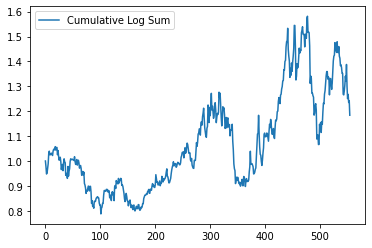

In [297]:
simple_returns.plot()

In [232]:
weights=preds_test.cpu().detach().numpy()

In [239]:
weights

array([[ 2.99984932e-01,  2.99984872e-01,  2.99984843e-01, ...,
        -1.83831595e-04, -1.83823053e-04, -1.83815806e-04],
       [ 2.99882352e-01,  2.99882323e-01,  2.99882293e-01, ...,
        -1.19657714e-04, -1.19665834e-04, -1.19667326e-04],
       [ 3.00106704e-01,  3.00106674e-01,  3.00106615e-01, ...,
        -4.14545466e-05, -4.14664501e-05, -4.14679671e-05],
       ...,
       [ 2.99844235e-01,  2.99844205e-01,  2.99844176e-01, ...,
        -2.00926283e-04, -2.00922092e-04, -2.00916606e-04],
       [ 2.99784929e-01,  2.99784899e-01,  2.99784780e-01, ...,
        -2.10333819e-04, -2.10338665e-04, -2.10345650e-04],
       [ 3.00065666e-01,  3.00065607e-01,  3.00065607e-01, ...,
        -8.68826828e-05, -8.68891293e-05, -8.68879724e-05]], dtype=float32)

In [314]:
y_test.shape

torch.Size([555, 1, 1, 10])

In [322]:
covarr=covmat.to_numpy()

In [315]:
returns_cov=torch.cov(y_test.squeeze()).cpu().detach().numpy()

In [316]:
torch.cov(y_test.squeeze()).shape

torch.Size([555, 555])

In [305]:
weights.shape

(555, 10)

In [337]:
portfolio_std=np.sqrt(weights*np.matrix(covarr)*weights.T)

In [338]:
std_data=pd.DataFrame(portfolio_std[0])

In [385]:
upper_confidence=simple_returns.add(std_data.T)

In [445]:
upper=simple_returns.to_numpy()+5*portfolio_std[0].T
lower=simple_returns.to_numpy()-5*portfolio_std[0].T

In [446]:
upper_confidence=pd.DataFrame(upper)
lower_confidence=pd.DataFrame(lower)

In [447]:
concat_bayes=pd.concat([lower_confidence,simple_returns["Cumulative Log Sum"],upper_confidence], axis=1)

In [450]:
concat_bayes=concat_bayes.set_axis(["Lower Confidence Bound","Cumulative Return","Upper Confidence Bound"],axis=1,inplace=False)

<AxesSubplot:>

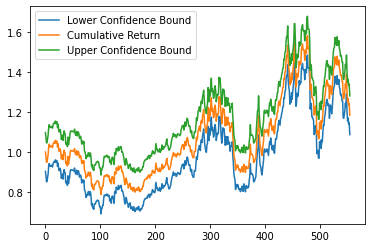

In [451]:
concat_bayes.plot()

In [154]:
dict.keys()

dict_keys(['1overN', 'random', 'network', 'Monte Carlo'])

In [251]:
dict["network"]
concatted=pd.concat([dict["1overN"],dict["random"],dict["network"],dict["Monte Carlo"]],axis=1)
concatted.reset_index(drop=True,inplace=True)
concatted.columns=['1overN', 'random', 'network', "Monte Carlo"]
concatted

,1overN,random,network,Monte Carlo
0,0.005137,-0.001426,-0.004381,-0.004252
1,-0.013867,-0.015748,-0.019148,-0.019610
2,0.000482,0.004569,0.002730,0.002435
3,0.000000,0.000000,0.000000,0.000000
4,0.013554,0.013247,0.018025,0.014325
...,...,...,...,...
509,0.013736,0.010183,0.021740,0.020504
510,0.038104,0.030801,0.059667,0.052374
511,-0.020457,-0.020387,-0.009777,-0.003925
512,-0.021024,-0.023932,-0.028589,-0.031730


In [463]:
np_cum=portfolio_returns(preds_test,y_test.squeeze(1), output_type="simple").cpu().detach().numpy()

In [464]:
deleted=np.delete(np_cum,range(41))

In [465]:
concatted["bayesian"]=deleted
concatted

,1overN,random,network,Monte Carlo,bayesian
0,0.005137,-0.001426,-0.004381,-0.004252,0.051453
1,-0.013867,-0.015748,-0.019148,-0.019610,-0.039688
2,0.000482,0.004569,0.002730,0.002435,0.020379
3,0.000000,0.000000,0.000000,0.000000,0.010694
4,0.013554,0.013247,0.018025,0.014325,0.030632
...,...,...,...,...,...
509,0.013736,0.010183,0.021740,0.020504,-0.037137
510,0.038104,0.030801,0.059667,0.052374,0.013751
511,-0.020457,-0.020387,-0.009777,-0.003925,-0.025788
512,-0.021024,-0.023932,-0.028589,-0.031730,0.005966


<AxesSubplot:>

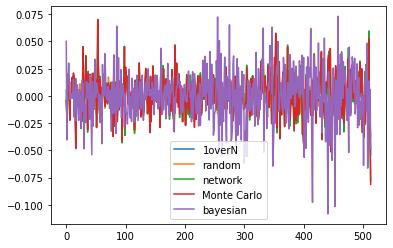

In [461]:
concatted.plot()

In [160]:
weight_table = generate_weights_table(network2, dataloader_test)

<AxesSubplot:>

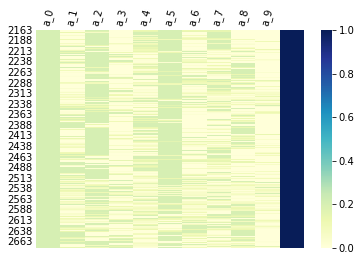

In [161]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)